PART 1 : STREAMING DATA HANDLING

In [0]:
dbutils.notebook.exit("Reset Notebook")


In [0]:
%reset -f


In [0]:
from pyspark.sql.functions import col


#read permanant table created as streaming data 
#streaming_df = spark.readStream.table("synthetic_fraud_data_parquet")  

##spark.read.table("") for batch processing


In [0]:
from pyspark.sql import SparkSession

# create spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()


In [0]:
#read permanant table created as batch data 
table_df = spark.read.table("synthetic_fraud_data_parquet")

# cast 'card_number' to string
table_df = table_df.withColumn("card_number", col("card_number").cast("string"))


# write the data to a directory, overwrite if necessary for repeated execution
table_df.write.mode("overwrite").format("parquet").save("/FileStore/tables/streaming_ready_data")



In [0]:
# drop ID column
columns_to_keep = [col for col in table_df.columns if col != "transaction_id"]
df_cleaned = table_df.select(*columns_to_keep)


In [0]:
df_cleaned.cache()


Out[7]: DataFrame[customer_id: string, card_number: string, timestamp: string, merchant_category: string, merchant_type: string, merchant: string, amount: double, currency: string, country: string, city: string, city_size: string, card_type: string, card_present: boolean, device: string, channel: string, device_fingerprint: string, ip_address: string, distance_from_home: bigint, high_risk_merchant: boolean, transaction_hour: bigint, weekend_transaction: boolean, velocity_last_hour: string, is_fraud: boolean]

In [0]:
# filter only fraudulent transactions
#df_fraud = df_cleaned.filter(col("is_fraud") == 1)
#commented for ml training detection for further use


In [0]:
df_cleaned.write.mode("overwrite").format("parquet").save("/FileStore/tables/streaming_ready_data")


In [0]:
# read the Parquet file as a batch
corrected_df = spark.read.format("parquet").load("/FileStore/tables/streaming_ready_data")

# print the schema to confirm 'card_number' is StringType
corrected_df.printSchema()


root
 |-- customer_id: string (nullable = true)
 |-- card_number: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- transaction_hour: long (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- velocity_last_hour: string (nullable = true)
 |-- is_fraud: boolean (nullable = tru

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType, LongType
# define the schema for the data
# done to specify schema for testing streaming data processing with a static dataset , else throwing error for undefined schema for readsteam
schema = StructType([
    StructField("customer_id", StringType(), True),
    StructField("card_number", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("merchant_category", StringType(), True),
    StructField("merchant_type", StringType(), True),
    StructField("merchant", StringType(), True),
    StructField("amount", DoubleType(), True),
    StructField("currency", StringType(), True),
    StructField("country", StringType(), True),
    StructField("city", StringType(), True),
    StructField("city_size", StringType(), True),
    StructField("card_type", StringType(), True),
    StructField("card_present", BooleanType(), True),  # Match BOOLEAN
    StructField("device", StringType(), True),
    StructField("channel", StringType(), True),
    StructField("device_fingerprint", StringType(), True),
    StructField("ip_address", StringType(), True),
    StructField("distance_from_home", LongType(), True),  # Match LONG
    StructField("high_risk_merchant", BooleanType(), True),  # Match BOOLEAN
    StructField("transaction_hour", LongType(), True),  # Match LONG
    StructField("weekend_transaction", BooleanType(), True),  # Match BOOLEAN
    StructField("velocity_last_hour", StringType(), True),
    StructField("is_fraud", BooleanType(), True)  # Match BOOLEAN
])


In [0]:
# read the streaming-ready data
streaming_df = spark.readStream \
    .schema(schema) \
    .format("parquet") \
    .load("/FileStore/tables/streaming_ready_data")

# write the streaming output to the console
#this is supposed to run indefinitely in production
small_streaming_df = streaming_df.limit(5000)
#does not stop processing after 5000, instead each batch is of size 5000
query = small_streaming_df.writeStream \
    .outputMode("append") \
    .format("console") \
    .start()
query.awaitTermination()
#limit set for databricks community edition


from threading import Timer

# set a timeout to stop the query
def stop_query():
    query.stop()

Timer(900, stop_query).start()  # stop after 10 seconds
query.awaitTermination()



In [0]:
query.stop()


END OF STREAMING DATA HANDLING

PART 2: DATA ANALYSIS, TREATING STREAMING READY DATA AS BATCH

In [0]:
# read the streaming-ready data as a batch
batch_df = spark.read.format("parquet").load("/FileStore/tables/streaming_ready_data")
batch_df.show(5)  # display first 5 rows


+-----------+----------------+--------------------+-----------------+-------------+------------+---------+--------+-------+------------+---------+-------------+------------+-----------+-------+--------------------+---------------+------------------+------------------+----------------+-------------------+--------------------+--------+
|customer_id|     card_number|           timestamp|merchant_category|merchant_type|    merchant|   amount|currency|country|        city|city_size|    card_type|card_present|     device|channel|  device_fingerprint|     ip_address|distance_from_home|high_risk_merchant|transaction_hour|weekend_transaction|  velocity_last_hour|is_fraud|
+-----------+----------------+--------------------+-----------------+-------------+------------+---------+--------+-------+------------+---------+-------------+------------+-----------+-------+--------------------+---------------+------------------+------------------+----------------+-------------------+--------------------+--

In [0]:
from pyspark.sql.functions import col, when, count

# count missing values for each column (works for all types)
missing_values = batch_df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in batch_df.columns
])
missing_values.show()
#no missing values


+-----------+-----------+---------+-----------------+-------------+--------+------+--------+-------+----+---------+---------+------------+------+-------+------------------+----------+------------------+------------------+----------------+-------------------+------------------+--------+
|customer_id|card_number|timestamp|merchant_category|merchant_type|merchant|amount|currency|country|city|city_size|card_type|card_present|device|channel|device_fingerprint|ip_address|distance_from_home|high_risk_merchant|transaction_hour|weekend_transaction|velocity_last_hour|is_fraud|
+-----------+-----------+---------+-----------------+-------------+--------+------+--------+-------+----+---------+---------+------------+------+-------+------------------+----------+------------------+------------------+----------------+-------------------+------------------+--------+
|          0|          0|        0|                0|            0|       0|     0|       0|      0|   0|        0|        0|           0| 

In [0]:
# extract numerical and categorical column names from the schema
numerical_columns = [
    field.name for field in schema.fields if isinstance(field.dataType, (DoubleType, LongType))
]
categorical_columns = [
    field.name for field in schema.fields if isinstance(field.dataType, StringType)
]
boolean_columns = [
    field.name for field in schema.fields if isinstance(field.dataType, BooleanType)
]

print(f"Numerical Columns: {numerical_columns}")
print(f"Categorical Columns: {categorical_columns}")
print(f"Boolean Columns: {boolean_columns}")


Numerical Columns: ['amount', 'distance_from_home', 'transaction_hour']
Categorical Columns: ['customer_id', 'card_number', 'timestamp', 'merchant_category', 'merchant_type', 'merchant', 'currency', 'country', 'city', 'city_size', 'card_type', 'device', 'channel', 'device_fingerprint', 'ip_address', 'velocity_last_hour']
Boolean Columns: ['card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']


In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# assemble numerical columns into a single feature vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
numerical_vector_df = assembler.transform(batch_df)

# apply StandardScaler
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(numerical_vector_df)
scaled_df = scaler_model.transform(numerical_vector_df)

# drop intermediate columns if needed
scaled_df = scaled_df.drop("numerical_features")
scaled_df.show(5)


+-----------+----------------+--------------------+-----------------+-------------+------------+---------+--------+-------+------------+---------+-------------+------------+-----------+-------+--------------------+---------------+------------------+------------------+----------------+-------------------+--------------------+--------+--------------------+
|customer_id|     card_number|           timestamp|merchant_category|merchant_type|    merchant|   amount|currency|country|        city|city_size|    card_type|card_present|     device|channel|  device_fingerprint|     ip_address|distance_from_home|high_risk_merchant|transaction_hour|weekend_transaction|  velocity_last_hour|is_fraud|     scaled_features|
+-----------+----------------+--------------------+-----------------+-------------+------------+---------+--------+-------+------------+---------+-------------+------------+-----------+-------+--------------------+---------------+------------------+------------------+----------------+-

In [0]:
# split the data into training and test sets (80-20 split)
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)


In [0]:
#%pip install sparkxgb


In [0]:
#%pip install xgboost


In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [0]:
# convert 'is_fraud' column from Boolean to Integer
train_df = train_df.withColumn("is_fraud", train_df["is_fraud"].cast("int"))
test_df = test_df.withColumn("is_fraud", test_df["is_fraud"].cast("int"))


In [0]:
# define the Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="scaled_features",  # The normalized features column
    labelCol="is_fraud",           # Target label column
    predictionCol="prediction",    # Output prediction column
    numTrees=100,                  # Number of trees
    maxDepth=5                     # Maximum depth of trees
)

# train the Random Forest Model
rf_model = rf.fit(train_df)
#takes 12 minutes


In [0]:
# make predictions on the test data
predictions = rf_model.transform(test_df)

# show predictions
predictions.select("scaled_features", "is_fraud", "prediction", "probability").show(5)

# evaluate accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="is_fraud", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Set Accuracy = {accuracy}")

+--------------------+--------+----------+--------------------+
|     scaled_features|is_fraud|prediction|         probability|
+--------------------+--------+----------+--------------------+
|[-0.0778816851148...|       1|       1.0|[0.12905519991216...|
|[-0.2624085200934...|       0|       0.0|[0.98018368721852...|
|[-0.2697649522777...|       1|       1.0|[0.06586876902662...|
|[-0.2653078277877...|       0|       0.0|[0.98133285889451...|
|[-0.2681975047274...|       1|       0.0|[0.73632228535888...|
+--------------------+--------+----------+--------------------+
only showing top 5 rows

Test Set Accuracy = 0.8981612806032908


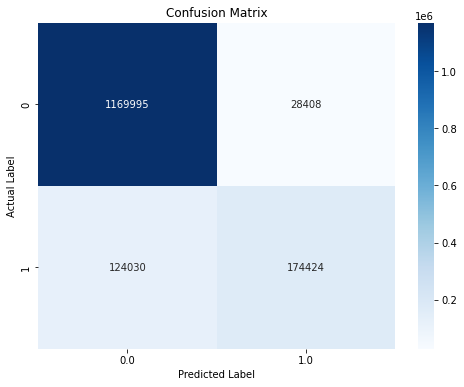

In [0]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create confusion matrix
confusion_matrix = predictions.groupBy("is_fraud", "prediction").count().toPandas()

# pivot the data for heatmap
confusion_matrix_pivot = confusion_matrix.pivot(index="is_fraud", columns="prediction", values="count").fillna(0)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pivot, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# define a UDF to extract the probability of fraud (second element in the array)
extract_probability = udf(lambda prob: float(prob[1]), DoubleType())

# add a new column for fraud probability
predictions = predictions.withColumn("fraud_probability", extract_probability(col("probability")))


In [0]:
predictions.select("fraud_probability", "is_fraud", "prediction").show(5)


+-------------------+--------+----------+
|  fraud_probability|is_fraud|prediction|
+-------------------+--------+----------+
| 0.8709448000878373|       1|       1.0|
|0.01981631278147209|       0|       0.0|
| 0.9341312309733703|       1|       1.0|
| 0.0186671411054881|       0|       0.0|
|0.26367771464111434|       1|       0.0|
+-------------------+--------+----------+
only showing top 5 rows



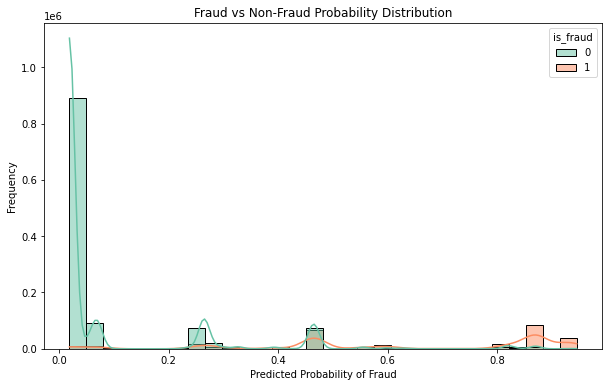

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# convert predictions to Pandas
predictions_pd = predictions.select("fraud_probability", "is_fraud").toPandas()

# plot fraud vs non-fraud probability distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=predictions_pd, x="fraud_probability", hue="is_fraud", kde=True, bins=30, palette="Set2")
plt.title("Fraud vs Non-Fraud Probability Distribution")
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Frequency")
plt.show()


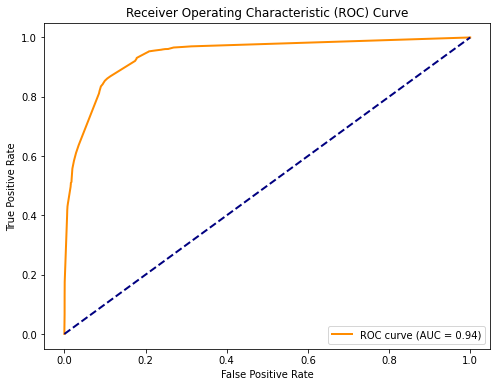

In [0]:
from sklearn.metrics import roc_curve, auc

# extract true labels and probabilities
y_true = predictions_pd["is_fraud"]
y_prob = predictions_pd["fraud_probability"]

# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
